In [1]:
import sys 
sys.path.append('../')

import torch
import matplotlib.pyplot as plt 
from einops import repeat

from src.green_net import GreenNet2D
from src.dd_gmg import DD_Grid2D
from src.model import MLP
from src.utils import rl2_error, matrl2_error
torch.set_printoptions(linewidth=150)

In [2]:
def DiskPoisson(pts):
    x1 = pts[...,0]
    y1 = pts[...,1]
    x2 = pts[...,2]
    y2 = pts[...,3]

    mask = ((x1**2+y1**2) < 1) & ((x2**2+y2**2) < 1)

    k = 1/(4*torch.pi) * torch.log(
        ((x1 - x2)**2 + (y1-y2)**2) / \
        ((x1*y2-x2*y1)**2 + (x1*x2+y1*y2-1)**2))
    k = torch.nan_to_num(k, neginf=-2) * mask

    return k

In [3]:
# def DiskInvdist(pts):
#     x1 = pts[...,0]
#     y1 = pts[...,1]
#     x2 = pts[...,2]
#     y2 = pts[...,3]

#     mask = ((x1**2+y1**2) < 1) & ((x2**2+y2**2) < 1)

#     k = ((x1 - x2)**2 + (y1-y2)**2) ** (-0.5)
#     k = torch.nan_to_num(k, posinf=70) * mask

#     return k

In [4]:
def ffunc_2D(pts):
    x = pts[:,0]
    y = pts[:,1]
    u = 1 - (x**2+y**2)
    u = torch.nan_to_num(u, posinf=0)
    return u

In [5]:
device = torch.device('cpu')
# kernel = MLP([2, 64, 1], nonlinearity='relu').to(device)
model = GreenNet2D(n=5, kernel=DiskPoisson, device=device)
# model = GreenNet2D(n=6, kernel=DiskInvdist, device=device, sub_num=5)

In [6]:
F = ffunc_2D(model.grid.x_h)
F = repeat(F, 'n -> n b', b=64)

Ground Truth Kernel Function

In [7]:
model.eval_K()
nh = model.grid.nh
K_full = model.K_hh.reshape(nh,nh,nh,nh)

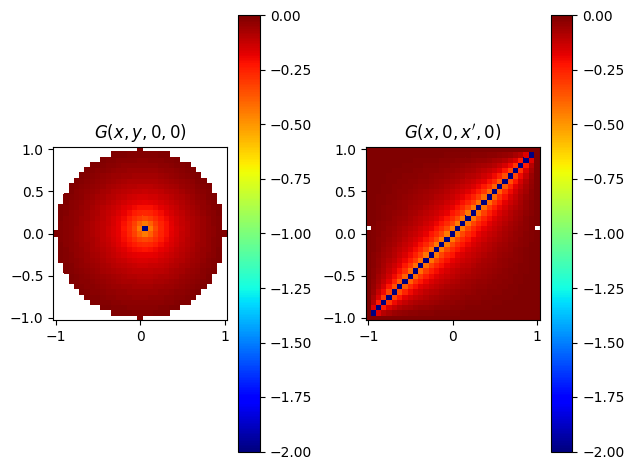

In [8]:
xy = model.grid.x_h.reshape(nh,nh,2)
mask = (xy[...,0]**2 + xy[...,1]**2) > 1
G_xy00 = K_full[:,:,17,17]
G_xy00[mask] = torch.nan
G_x0y0 = K_full[:,17,:,17]
plt.subplot(121)
plt.pcolor(xy[...,0], xy[...,1], G_xy00, cmap='jet')
plt.title('$G(x,y,0,0)$')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.subplot(122)
plt.pcolor(xy[...,0], xy[...,1], G_x0y0, cmap='jet')
plt.title('$G(x,0,x\',0)$')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.tight_layout()

Full Kernel Integral

In [9]:
F = ffunc_2D(model.grid.x_h)
F = repeat(F, 'n -> n b', b=64)
U_full = model.full_kint(F)
print(U_full.shape)
f = F[:,0].reshape(nh,nh)
u = U_full[:,0].reshape(nh,nh)
f[mask] = torch.nan 
u[mask] = torch.nan

torch.Size([1089, 64])


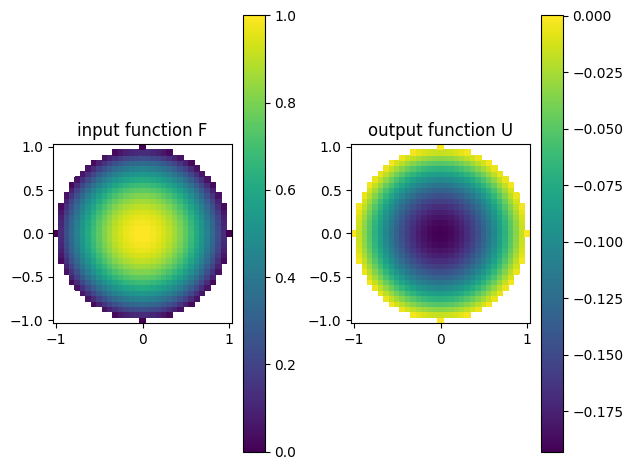

In [10]:
plt.subplot(121)
plt.pcolor(xy[...,0], xy[...,1], f)
plt.title('input function F')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.subplot(122)
plt.pcolor(xy[...,0], xy[...,1], u)
plt.title('output function U')
plt.gca().set_aspect('equal')
plt.colorbar()
plt.tight_layout()

In [11]:
from src.dd_gmg import DD_Grid2D, DD_GMG2D
from src.ops import fetch_nbrs2d, cat2d_nbr_coords, interp2d, coord2idx4d, coord2idx2d
from einops import rearrange 

In [12]:
gmg2d = DD_GMG2D(6, 1, 3, DiskPoisson, device)

# coarest pts :  6561
# correction :  120848
ratio 127409/17850625 = 0.71% 



In [13]:
F = ffunc_2D(model.grid.x_h)
F = repeat(F, 'n -> n b', b=64)

In [14]:
n = 5
k = 1
xy = model.grid.x_h.reshape(nh,nh,2)
mask = (xy[...,0]**2 + xy[...,1]**2) < 1

for m in [0, 1, 3, 7, 15, 31, 65]:
    dd_gmg = DD_GMG2D(n,m,k,DiskPoisson,device)
    dd_gmg.restrict_ml_f(F)
    dd_gmg.eval_ml_K()
    U_dd = dd_gmg.ml_kint(corr_odd=False)
    rl2 = rl2_error(U_dd.reshape(nh,nh,-1)[mask].T, U_full.reshape(nh,nh,-1)[mask].T)

    print('k {:d} - m {:d} - rl2 {:.4e}\n'.format(k, m, rl2))

# coarest pts :  83521
# correction :  0
ratio 83521/1185921 = 7.04% 

k 1 - m 0 - rl2 9.0862e-02

# coarest pts :  83521
# correction :  22880
ratio 106401/1185921 = 8.97% 

k 1 - m 1 - rl2 8.2155e-02

# coarest pts :  83521
# correction :  138320
ratio 221841/1185921 = 18.71% 

k 1 - m 3 - rl2 8.2316e-02

# coarest pts :  83521
# correction :  518408
ratio 601929/1185921 = 50.76% 

k 1 - m 7 - rl2 8.2486e-02

# coarest pts :  83521
# correction :  1090520
ratio 1174041/1185921 = 99.00% 

k 1 - m 15 - rl2 8.2433e-02

# coarest pts :  83521
# correction :  1102400
ratio 1185921/1185921 = 100.00% 

k 1 - m 31 - rl2 8.2433e-02

# coarest pts :  83521
# correction :  1102400
ratio 1185921/1185921 = 100.00% 

k 1 - m 65 - rl2 8.2433e-02



In [15]:
n, m, k = 5, 3, 1

F = ffunc_2D(model.grid.x_h)
F = repeat(F, 'n -> n b', b=64)

dd_gmg = DD_GMG2D(n,m,k,DiskPoisson,device)
dd_gmg.restrict_ml_f(F)
dd_gmg.eval_ml_K()

# coarest pts :  83521
# correction :  138320
ratio 221841/1185921 = 18.71% 



In [16]:
dd_gmg.ml_grids[0].init_grid_hh()
nh = dd_gmg.ml_grids[0].nh
x_hh = dd_gmg.ml_grids[0].x_hh
coords_ij = dd_gmg.ml_grids[0].coords_ij
mask_ij = dd_gmg.ml_grids[0].mask_ij
K_hh = dd_gmg.kernel(x_hh).reshape(nh,nh,nh,nh)
K_ij_gt = K_hh[coords_ij[...,0], coords_ij[...,1], 
                      coords_ij[...,2], coords_ij[...,3]] * mask_ij

In [17]:
K_ij_gt.shape

torch.Size([33, 33, 7, 7])

In [18]:
K_ij_gt[17,17]

tensor([[-0.2137, -0.2390, -0.2593, -0.2671, -0.2581, -0.2366, -0.2101],
        [-0.2390, -0.2770, -0.3138, -0.3310, -0.3126, -0.2746, -0.2353],
        [-0.2593, -0.3138, -0.3861, -0.4406, -0.3849, -0.3113, -0.2556],
        [-0.2671, -0.3310, -0.4406, -2.0000, -0.4394, -0.3285, -0.2633],
        [-0.2581, -0.3126, -0.3849, -0.4394, -0.3836, -0.3101, -0.2543],
        [-0.2366, -0.2746, -0.3113, -0.3285, -0.3101, -0.2720, -0.2327],
        [-0.2101, -0.2353, -0.2556, -0.2633, -0.2543, -0.2327, -0.2062]])

In [19]:
u_h = dd_gmg.coarest_full_kint()
coords_IJ = dd_gmg.ml_grids[-1].coords_ij
mask_IJ = dd_gmg.ml_grids[-1].mask_ij
K_IJ = dd_gmg.K_HH[coords_IJ[...,0], coords_IJ[...,1], 
                   coords_IJ[...,2], coords_IJ[...,3]] * mask_IJ

l = 1
nh = dd_gmg.ml_grids[-1-l].nh
hh = dd_gmg.ml_grids[-1-l].hh
f_h = dd_gmg.ml_f[-1-l].reshape(-1,nh*nh).T

# local evaluation and assemblation
K_local_even, K_local_odd = dd_gmg.K_locals[l-1]
K_ij = dd_gmg.local_assemble_K(K_IJ, K_local_even, K_local_odd)

In [20]:
K_ij[17,17]

tensor([[-0.1070, -0.1196, -0.1317, -0.1427, -0.1514, -0.1570, -0.1586, -0.1558, -0.1490, -0.1391, -0.1270, -0.1137,
         -0.0999],
        [-0.1196, -0.1349, -0.1500, -0.1643, -0.1764, -0.1845, -0.1870, -0.1833, -0.1740, -0.1607, -0.1452, -0.1288,
         -0.1124],
        [-0.1317, -0.1500, -0.1692, -0.1882, -0.2054, -0.2177, -0.2219, -0.2165, -0.2029, -0.1846, -0.1643, -0.1440,
         -0.1245],
        [-0.1427, -0.1643, -0.1882, -0.2137, -0.2390, -0.2593, -0.2671, -0.2581, -0.2366, -0.2101, -0.1833, -0.1582,
         -0.1353],
        [-0.1514, -0.1764, -0.2054, -0.2390, -0.2770, -0.3138, -0.3310, -0.3126, -0.2746, -0.2353, -0.2004, -0.1702,
         -0.1440],
        [-0.1570, -0.1845, -0.2177, -0.2593, -0.3138, -0.3861, -0.4406, -0.3849, -0.3113, -0.2556, -0.2127, -0.1783,
         -0.1496],
        [-0.1586, -0.1870, -0.2219, -0.2671, -0.3310, -0.4406, -2.0000, -0.4394, -0.3285, -0.2633, -0.2169, -0.1807,
         -0.1511],
        [-0.1558, -0.1833, -0.2165, -0.2581, -0.